## Level2 - Word Embeddings (Word2Vec, GloVe)

## GloVe: Global Vectors for Word Representation

GloVe is an **unsupervised learning algorithm** for obtaining vector representations for words. It combines the benefits of two main types of word embeddings:

- **Count-based models** (like LSA) that leverage word co-occurrence matrices
- **Predictive models** (like Word2Vec) that use context to predict word occurrence

### Core Idea

If two words appear in **similar contexts**, they are likely to have **similar meanings**. GloVe captures this by analyzing the **co-occurrence statistics** of words across a corpus.

---

### Co-occurrence Matrix

Let:

- $X_{ij}$ = number of times word $j$ appears in the context of word $i$


GloVe is based on co-occurrence counts. Specifically, it builds a large matrix $𝑋$ where:    
$𝑋_{𝑖𝑗}$ = number of times word $j$ appears in the context of word $i$ in the corpus.

*Example*:

Suppose your corpus is: "The cat sat on the mat."

You define a context window size, say 2 words to the left and right.

Now walk through each word and count how often other words appear near it.

Then the **ratio** of probabilities is important:    
Let:    
- $P_{ik} = $  Probability that word $k$ appears in context of $i$    
- $P_{jk} = $  Probability that word $k$ appears in context of $j$    


$$
\frac{P_{ik}}{P_{jk}} = 
\frac{X_{ik}/X_i}{X_{jk}/X_j}
$$

This ratio tells us how much more likely word $k$ is to appear near word $i$ than word $j$.   
This ratio is what defines the relative meaning between $i$ and $j$ using $k$ as probe.

--- 

### What’s Learned?
Each word gets a vector.

Words with similar contexts have similar vectors.

Vectors support linear reasoning:

$ \text{vec("king")−vec("man")+vec("woman")≈vec("queen")}$

---

### The GloVe Model

We define word vectors $w_i$ and context vectors $\tilde{w}_j$ such that their dot product predicts $X_{ij}$:

$$
w_i^\top \tilde{w}_j + b_i + \tilde{b}_j = \log(X_{ij})
$$

Where:

- $w_i$, $\tilde{w}_j$ = word and context embeddings
- $b_i$, $\tilde{b}_j$ = bias terms
- $X_{ij}$ = number of co-occurrences between words $i$ and $j$   

  Note: dimentionality of vocabulary space $V$ is large - possibly in billions of words   
  However dimensionalitt if each word representing vector $w_i$ is much smaller -    
  50 to 300.      


This leads to the **loss function**:

$$
J = \sum_{i,j=1}^{V} f(X_{ij}) \left(w_i^\top \tilde{w}_j + b_i + \tilde{b}_j - \log(X_{ij}) \right)^2
$$


Where:

- $f(X_{ij})$ is a weighting function to reduce the impact of very frequent word pairs  

Training: GloVe builds a co-occurrence matrix $X_{ij}$ (how often word i appears near word j)    
then choses $w_i$, $\tilde{w}_j$, $b_i$, $\tilde{b}_j$ to minimize loss function. 

---

### Final Embedding

After training, the final embedding for each word is often:

$$
	\text{embedding}(i) = w_i + \tilde{w}_i
$$

---

## Summary

- GloVe captures **global co-occurrence statistics**
- Produces dense vector embeddings
- Trained on massive corpora (e.g., Wikipedia, Common Crawl)
- Embeddings reflect semantic similarity:  
  e.g., `king - man + woman ≈ queen`

## References    

### Foundational Paper
Title: **GloVe: Global Vectors for Word Representation**

Authors: Jeffrey Pennington, Richard Socher, Christopher D. Manning

Conference: EMNLP 2014

Link: https://aclanthology.org/D14-1162/

PDF: https://nlp.stanford.edu/pubs/glove.pdf

This is the core paper introducing the model, showing how word vectors can be learned from global word-word co-occurrence statistics.


### Official Project Page
Stanford NLP GloVe site:
https://nlp.stanford.edu/projects/glove/
Includes:

Pre-trained vectors (50D, 100D, 200D, 300D)

Code and dataset download links

Instructions for training on your own corpus


### Code Repositories
Original Stanford GloVe code (C implementation)
https://github.com/stanfordnlp/GloVe

Python wrappers and tutorials:

glove-python: https://github.com/maciejkula/glove-python

Gensim wrapper: https://radimrehurek.com/gensim/models/word2vec.html
(GloVe vectors can be loaded into gensim like Word2Vec)

### Additional Learning Resources
[Stanford CS224N (Natural Language Processing with Deep Learning)](https://web.stanford.edu/class/cs224n/)

Lecture videos and notes

Covers word embeddings and contextual models

Blog Tutorials:

[Sebastian Ruder – Word Embeddings Explored](https://www.ruder.io/word-embeddings-1/)

[Jay Alammar – Visualizing Word Embeddings](https://jalammar.github.io/illustrated-word2vec/)

In [13]:
GLOVE_DIM = 200 # set to 50, 100, 200, or 300 depending on the glove file used
REMOVE_STOPWORDS = True # Set to True to remove stopwords, False to keep them
LEMATIZE = False # Set to True to lemmatize words, False to keep them as is
LOAD_ALL_GLOVE = False # Set to True to load all GloVe vectors, False to load only the ones in the text

### 0. Load pre-trained GloVe vectors

Manually download [glove.6B.zip](https://nlp.stanford.edu/data/glove.6B.zip), unzip it and set path:

In [2]:
glove_path = "D:/work/_Languages/Python/glove/glove.6B.200d.txt"

**OR** use this code (OS agnostic)

In [3]:
import os
import zipfile
import requests

GLOVE_ZIP_URL = "http://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_FOLDER = "glove"
GLOVE_ZIP_PATH = "glove.zip"

if not os.path.exists(GLOVE_FOLDER):
    print("Downloading GloVe vectors (bypassing SSL verification)...")
    response = requests.get(GLOVE_ZIP_URL, verify=False)
    with open(GLOVE_ZIP_PATH, 'wb') as f:
        f.write(response.content)

    print("Extracting...")
    with zipfile.ZipFile(GLOVE_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(GLOVE_FOLDER)

    os.remove(GLOVE_ZIP_PATH)

glove_path = f"{GLOVE_FOLDER}/glove.6B.{GLOVE_DIM}d.txt"
print(f"GloVe ready at: {glove_path}")


GloVe ready at: glove/glove.6B.200d.txt


### 1. Imports, setup and downloads

In [4]:
import numpy as np
import nltk
import re
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# One-time downloads
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Stopword set
if REMOVE_STOPWORDS:
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    
if LEMATIZE:
    nltk.download('averaged_perceptron_tagger')
    nltk.download('wordnet')
    from nltk import pos_tag
    from nltk.corpus import wordnet
    from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tom_n\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tom_n\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tom_n\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tom_n\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Sample Documents (longer texts)

In [5]:
docs = [
    """Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language. It focuses on how to program computers to process and analyze large amounts of natural language data.""",

    """Machine learning (ML) is a type of artificial intelligence that enables systems to learn and improve from experience without being explicitly programmed. ML algorithms build a mathematical model based on sample data, known as training data, to make predictions or decisions.""",

    """The Federal Reserve raised interest rates to combat inflation. Higher interest rates can slow borrowing, reduce consumer spending, and cool down an overheating economy. Investors reacted to the Fed's decisions with market volatility."""
]

labels = ["NLP", "Machine Learning", "Interest Rates"]


### 2. Tokenize and build Vocabulary from Docs


In [6]:
if LEMATIZE:
    lemmatizer = WordNetLemmatizer()
    
    # Helper: Convert POS tag to WordNet format
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
           return wordnet.VERB
        elif treebank_tag.startswith('N'):
           return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  # Default

In [7]:
def preprocess_tokens(text):
    tokens = word_tokenize(text.lower())
    tokens = [w for w in tokens if w.isalpha()]
    
    if REMOVE_STOPWORDS:
        tokens = [w for w in tokens if w not in stop_words]
    
    if LEMATIZE:
        tagged = pos_tag(tokens)
        tokens = [
            lemmatizer.lemmatize(w, get_wordnet_pos(pos))
            for w, pos in tagged
        ]
    return tokens


In [8]:
# extract doc vocab
def extract_tokens(doc):
    tokens = preprocess_tokens(doc.lower())
    return tokens

In [9]:

# Collect all needed tokens from the documents
def extract_vocab(docs):
    vocab = set()
    for doc in docs:
        tokens = extract_tokens(doc)
        vocab.update(tokens)
    return vocab

vocab = extract_vocab(docs)


### 3. Load Only Needed GloVe Vectors

In [10]:
if LOAD_ALL_GLOVE:
    print("Loading all GloVe vectors...")
    import numpy as np
    # Load all GloVe vectors
    def load_glove_all(path):
        glove = {}
        with open(path, encoding="utf8") as f:
            for line in f:
                word, *vec = line.split()
                glove[word] = np.array(vec, dtype='float32')
        return glove

    glove = load_glove_all(glove_path)
    print(f"Loaded {len(glove)} word vectors from GloVe.")
    
    # def load_glove_vectors(path):
    #     embeddings = {}
    #     with open(path, encoding="utf8") as f:
    #         for line in f:
    #             values = line.split()
    #             word = values[0]
    #             vec = np.array(values[1:], dtype='float32')
    #             embeddings[word] = vec
    #     return embeddings

    # glove = load_glove_vectors(glove_path)
    # print("Loaded GloVe. Total words:", len(glove))
else:
    print("Loading GloVe vectors that we need...")
    # Load only vectors we need
    def load_glove_subset(path, vocab, dim=100):
        glove = {}
        with open(path, encoding="utf8") as f:
            for line in f:
                word, *vec = line.split()
                if word in vocab:
                    glove[word] = np.array(vec, dtype='float32')
                if len(glove) == len(vocab):
                    break
        return glove

    #glove_path = "D:/data/glove.6B.300d.txt"  # adjust if needed
    glove = load_glove_subset(glove_path, vocab)
    print(f"Loaded {len(glove)} word vectors out of {len(vocab)} requested.")


Loading GloVe vectors that we need...
Loaded 65 word vectors out of 65 requested.


### 5. Convert Documents to Average Vectors

In [11]:
# Convert doc to averaged vector
def doc_to_vec(text, glove, dim=GLOVE_DIM):
    tokens = extract_tokens(text)
    vecs = [glove[w] for w in tokens if w in glove]
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

doc_vectors = np.array([doc_to_vec(doc, glove) for doc in docs])


### 6. Cosine Similarity + Heatmap

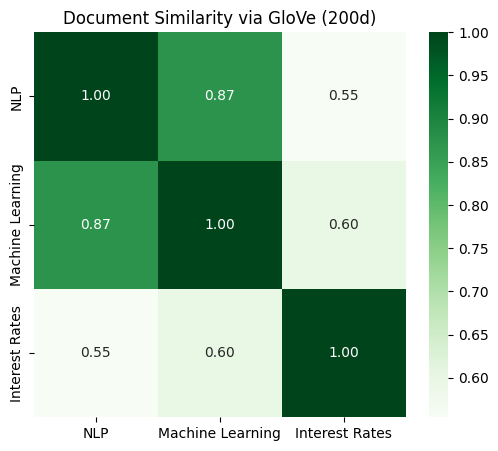

TF-IDF Cosine Similarity Matrix:
[[1.   0.87 0.55]
 [0.87 1.   0.6 ]
 [0.55 0.6  1.  ]]
Glove dim: 200
Stop-words removed: True  | Lemmatization: False


In [12]:
cos_sim = cosine_similarity(doc_vectors)

plt.figure(figsize=(6, 5))
sns.heatmap(cos_sim, annot=True, xticklabels=labels, yticklabels=labels, cmap="Greens", fmt=".2f")
plt.title(f"Document Similarity via GloVe ({GLOVE_DIM}d)")
plt.show()

# Display matrix
print("TF-IDF Cosine Similarity Matrix:")
print(np.round(cos_sim, 2))

print(f"Glove dim: {GLOVE_DIM}")
print(f"Stop-words removed: {REMOVE_STOPWORDS}  | Lemmatization: {LEMATIZE}")